In [50]:
import numpy as np
np.random.seed(0) 
import pandas as pd

#Tensorflow
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.datasets import mnist

from livelossplot.tf_keras import PlotLossesCallback

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs

import xgboost as xgb
import catboost as ctb 
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import scikitplot as skplt

### LOADING DATASET

In [46]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


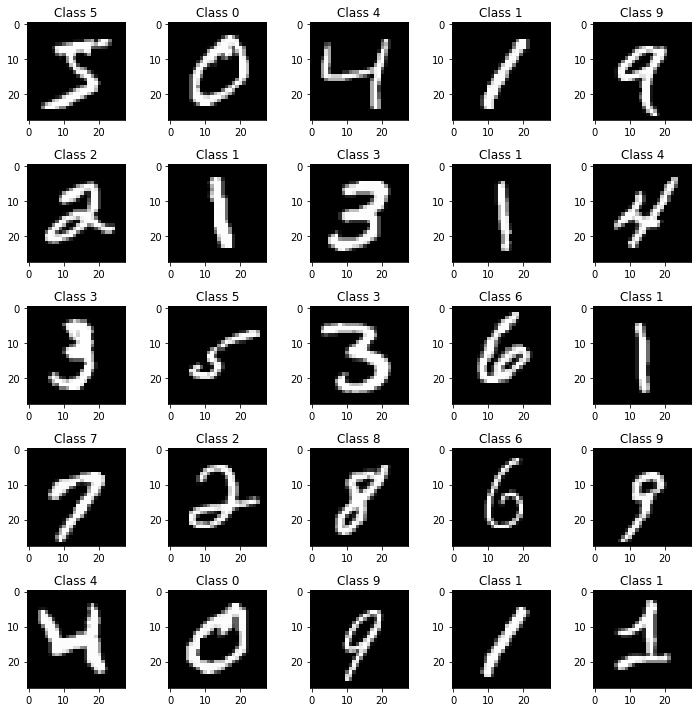

In [5]:
fig = plt.figure(figsize=(10, 10))
for idx in range(25):
    plt.subplot(5,5,idx+1)
    plt.imshow(X_train[idx], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[idx]))
    
plt.tight_layout()

In [47]:
#reshape
if len(X_train.shape) == 3:
    num_pixels = X_train.shape[1] * X_train.shape[2]
    X_train = X_train.reshape(X_train.shape[0], num_pixels).astype("float32")
    X_test = X_test.reshape(X_test.shape[0], num_pixels).astype("float32")

# data normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

input_dim = X_train.shape[1]
num_classes = 10

# one-hot encoding for target variable
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [48]:
input_dim= X_train.shape[1]
model = Sequential([
        Dense(512, input_dim=input_dim, activation='relu'),
        Dropout(0.45),
        
        Dense(256, activation='relu'),
        Dropout(0.2),
        
        Dense(128, activation='relu'),
        Dropout(0.2),
        
        Dense(num_classes, kernel_initializer='normal', activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
          batch_size=32, epochs=20, verbose=2,
          validation_data=(X_test, y_test))


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 10)               

In [7]:
def model_metrics_learning_curve():
    
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print("MLP Error: %.2f%%" % (100-score[1]*100))
    
    plt.figure(figsize=(15,10))
    plt.plot(history.history['accuracy'],label='accuracy')
    plt.plot(history.history['val_accuracy'],label='val_accuracy')
    plt.legend()
    plt.show()

    


Test loss: 0.07324614565033467
Test accuracy: 0.9834
MLP Error: 1.66%


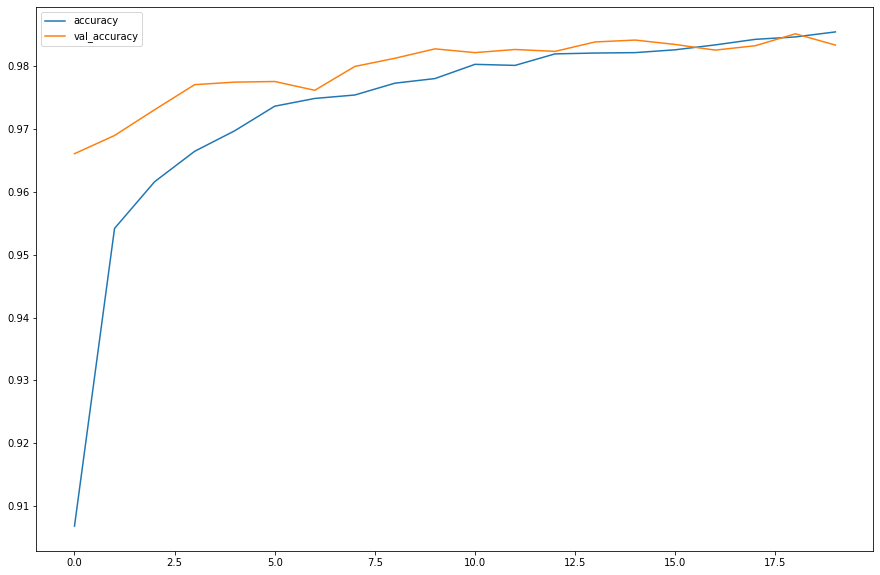

In [29]:
model_metrics_learning_curve()

In [40]:
def get_diff(y_test, y_pred):
    for idx, (a, b) in enumerate(zip(y_test, y_pred)):
        if np.argmax(a) == np.argmax(b): continue
        yield idx, np.argmax(a), np.argmax(b)

def plot_fail_predictions(limit=20):
    limit = 20
    cur_limit = 0
    fig = plt.figure(figsize=(10, 10))
    X_test_plot = X_test.reshape( [10000,28,28] )

    for it, (idx, y_test_val, y_pred_val) in enumerate(get_diff(y_test, y_pred)):
        if cur_limit > limit: break

        plt.subplot(5,5,it+1)
        plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
        plt.title('y_true={0}\ny_pred={1}'.format(y_test_val, y_pred_val))
        plt.tight_layout()

        cur_limit += 1

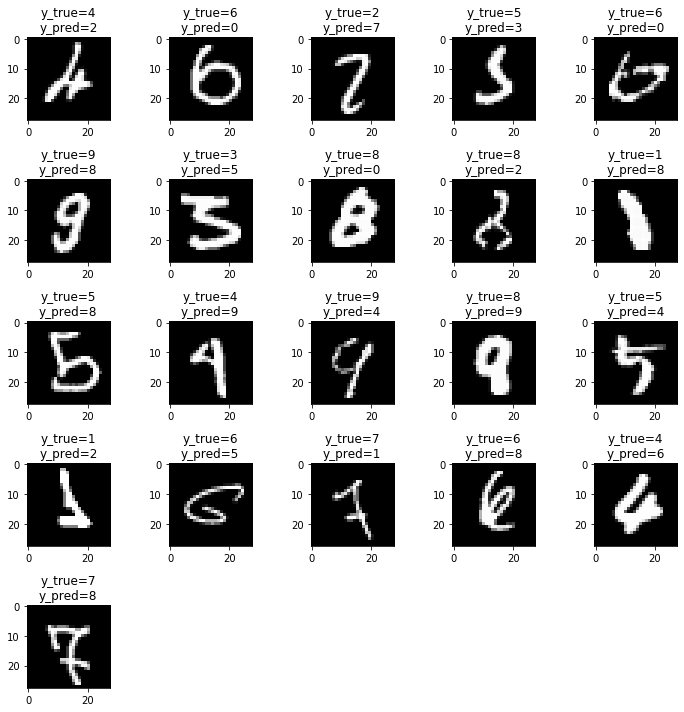

In [49]:
plot_fail_predictions()

# Convolutional neutral networks

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [45]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_last':
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
else:
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    
print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
# data normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

num_classes = 10

# one-hot encoding for target variable
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
def cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25), 
        
        Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(), # spłaszczanie danych, aby połączyć warstwy konwolucyjne z fully connected layers
        
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

model = cnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train,
          batch_size=32, epochs=20, verbose=2,
          validation_data=(X_test, y_test))

Test loss: 0.025509398350200635
Test accuracy: 0.9938
MLP Error: 0.62%


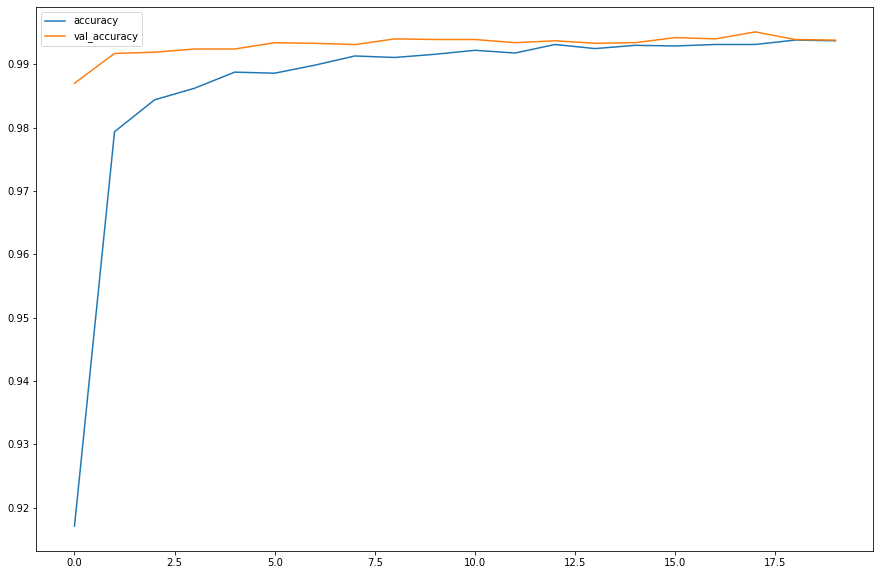

In [39]:
model_metrics_learning_curve()

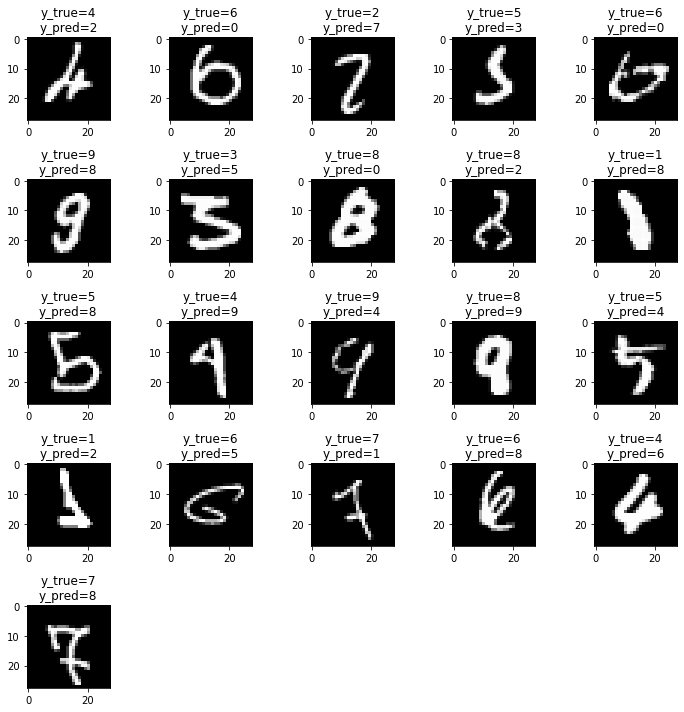

In [41]:
# check fail predicted images
plot_fail_predictions()

# XGBOOST 

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [4]:
#reshape
if len(X_train.shape) == 3:
    num_pixels = X_train.shape[1] * X_train.shape[2]
    X_train = X_train.reshape(X_train.shape[0], num_pixels).astype("float32")
    X_test = X_test.reshape(X_test.shape[0], num_pixels).astype("float32")
    
# data normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print(X_train.shape, X_test.shape)

(60000, 784) (10000, 784)


In [4]:
model = xgb.XGBClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print('Accuracy :', accuracy_score(y_test,y_pred))

Accuracy : 0.9368


In [5]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror'
    }
    
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = -accuracy_score(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=8,
            trials=trials)

print("The best params: ", best_params)


100%|█████████████████████████████████████████████████████████| 8/8 [6:06:31<00:00, 2748.99s/trial, best loss: -0.9765]
The best params:  {'x_colsample_bytree': 0.9123248798278353, 'x_learning_rate': 0.19641919947328704, 'x_max_depth': 13.0, 'x_min_child_weight': 5.0, 'x_random_state': 3550.0, 'x_reg_alpha': 1.0400291211838093, 'x_reg_lambda': 0.7042733314593094, 'x_subsample': 0.9999258084468287}


In [13]:
best_params = {'x_colsample_bytree': 0.9123248798278353,
 'x_learning_rate': 0.19641919947328704,
 'x_max_depth': 13.0,
 'x_min_child_weight': 5.0,
 'x_random_state': 3550.0,
 'x_reg_alpha': 1.0400291211838093,
 'x_reg_lambda': 0.7042733314593094,
 'x_subsample': 0.9999258084468287}

In [14]:
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1,
              x_colsample_bytree=0.9123248798278353,
              x_learning_rate=0.19641919947328704, x_max_depth=13.0,
              x_min_child_weight=5.0, x_random_state=3550.0,
              x_reg_alpha=1.0400291211838093, x_reg_lambda=0.7042733314593094, ...)

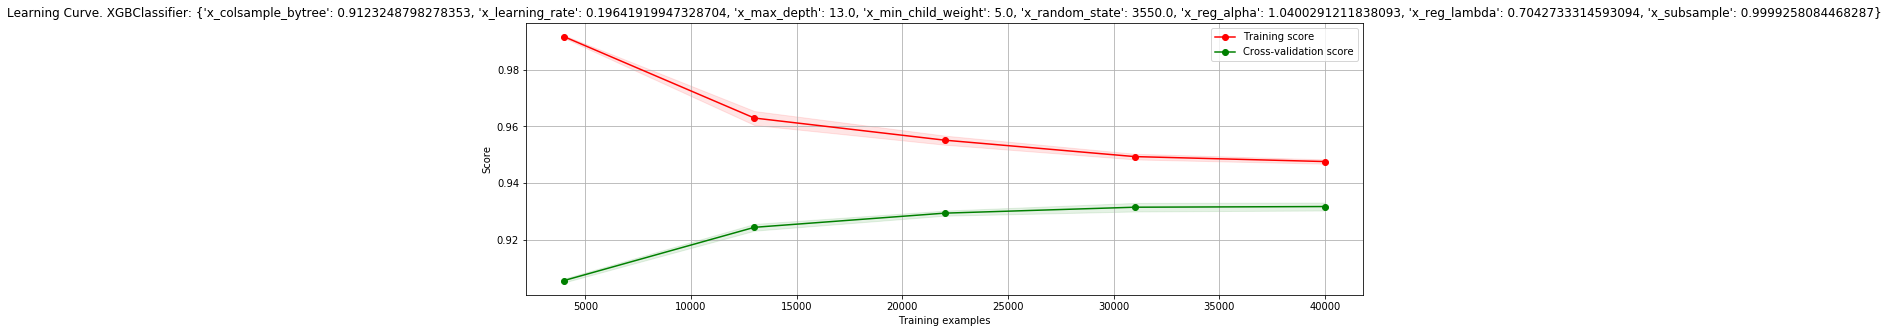

In [23]:
title='Learning Curve. {0}: {1}'.format('XGBClassifier with best_params')
skplt.estimators.plot_learning_curve(model, X_train,y_train,title=title,figsize=(15, 5), cv=3, scoring='accuracy')

# CATBOOST

In [49]:
best_params = {
 'depth': 13.0,
 'random_state': 3550.0,
 'learning_rate': 0.19641919947328704}


model = ctb.CatBoostClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print('Accuracy :', accuracy_score(y_test,y_pred))

Learning rate set to 0.097501
0:	learn: 2.0000537	total: 1.18s	remaining: 19m 42s
1:	learn: 1.8077927	total: 2.31s	remaining: 19m 13s
2:	learn: 1.6561870	total: 3.45s	remaining: 19m 7s
3:	learn: 1.5398948	total: 4.59s	remaining: 19m 4s
4:	learn: 1.4392984	total: 5.75s	remaining: 19m 3s
5:	learn: 1.3385143	total: 6.96s	remaining: 19m 13s
6:	learn: 1.2513720	total: 8.18s	remaining: 19m 20s
7:	learn: 1.1839052	total: 9.35s	remaining: 19m 19s
8:	learn: 1.1195482	total: 10.6s	remaining: 19m 25s
9:	learn: 1.0614344	total: 11.8s	remaining: 19m 24s
10:	learn: 1.0052661	total: 12.9s	remaining: 19m 22s
11:	learn: 0.9590889	total: 14.1s	remaining: 19m 22s
12:	learn: 0.9149452	total: 15.3s	remaining: 19m 21s
13:	learn: 0.8804072	total: 16.5s	remaining: 19m 18s
14:	learn: 0.8407541	total: 17.7s	remaining: 19m 22s
15:	learn: 0.8124875	total: 18.9s	remaining: 19m 21s
16:	learn: 0.7847183	total: 20.1s	remaining: 19m 20s
17:	learn: 0.7536690	total: 21.3s	remaining: 19m 20s
18:	learn: 0.7260218	total: 2

153:	learn: 0.1477939	total: 3m 1s	remaining: 16m 38s
154:	learn: 0.1468808	total: 3m 2s	remaining: 16m 37s
155:	learn: 0.1464068	total: 3m 4s	remaining: 16m 36s
156:	learn: 0.1459507	total: 3m 5s	remaining: 16m 35s
157:	learn: 0.1458230	total: 3m 6s	remaining: 16m 34s
158:	learn: 0.1454687	total: 3m 7s	remaining: 16m 33s
159:	learn: 0.1452775	total: 3m 8s	remaining: 16m 31s
160:	learn: 0.1445287	total: 3m 10s	remaining: 16m 30s
161:	learn: 0.1438639	total: 3m 11s	remaining: 16m 29s
162:	learn: 0.1435309	total: 3m 12s	remaining: 16m 28s
163:	learn: 0.1434349	total: 3m 13s	remaining: 16m 27s
164:	learn: 0.1432929	total: 3m 14s	remaining: 16m 25s
165:	learn: 0.1431961	total: 3m 15s	remaining: 16m 24s
166:	learn: 0.1431377	total: 3m 17s	remaining: 16m 23s
167:	learn: 0.1425342	total: 3m 18s	remaining: 16m 22s
168:	learn: 0.1424158	total: 3m 19s	remaining: 16m 21s
169:	learn: 0.1417959	total: 3m 20s	remaining: 16m 20s
170:	learn: 0.1416637	total: 3m 21s	remaining: 16m 18s
171:	learn: 0.140

304:	learn: 0.1168537	total: 5m 59s	remaining: 13m 39s
305:	learn: 0.1168308	total: 6m	remaining: 13m 38s
306:	learn: 0.1167588	total: 6m 1s	remaining: 13m 36s
307:	learn: 0.1163973	total: 6m 2s	remaining: 13m 35s
308:	learn: 0.1161384	total: 6m 4s	remaining: 13m 34s
309:	learn: 0.1160312	total: 6m 5s	remaining: 13m 33s
310:	learn: 0.1159767	total: 6m 6s	remaining: 13m 31s
311:	learn: 0.1155917	total: 6m 7s	remaining: 13m 30s
312:	learn: 0.1153286	total: 6m 8s	remaining: 13m 29s
313:	learn: 0.1152831	total: 6m 9s	remaining: 13m 28s
314:	learn: 0.1151775	total: 6m 11s	remaining: 13m 27s
315:	learn: 0.1149005	total: 6m 12s	remaining: 13m 25s
316:	learn: 0.1147521	total: 6m 13s	remaining: 13m 24s
317:	learn: 0.1146503	total: 6m 14s	remaining: 13m 23s
318:	learn: 0.1145111	total: 6m 15s	remaining: 13m 22s
319:	learn: 0.1144205	total: 6m 17s	remaining: 13m 21s
320:	learn: 0.1140724	total: 6m 18s	remaining: 13m 20s
321:	learn: 0.1139443	total: 6m 19s	remaining: 13m 18s
322:	learn: 0.1139017	

455:	learn: 0.0998710	total: 8m 56s	remaining: 10m 40s
456:	learn: 0.0998568	total: 8m 57s	remaining: 10m 39s
457:	learn: 0.0997844	total: 8m 59s	remaining: 10m 37s
458:	learn: 0.0996946	total: 9m	remaining: 10m 36s
459:	learn: 0.0996539	total: 9m 1s	remaining: 10m 35s
460:	learn: 0.0996061	total: 9m 2s	remaining: 10m 34s
461:	learn: 0.0995101	total: 9m 3s	remaining: 10m 33s
462:	learn: 0.0994255	total: 9m 4s	remaining: 10m 31s
463:	learn: 0.0993820	total: 9m 5s	remaining: 10m 30s
464:	learn: 0.0993372	total: 9m 7s	remaining: 10m 29s
465:	learn: 0.0991632	total: 9m 8s	remaining: 10m 28s
466:	learn: 0.0991234	total: 9m 9s	remaining: 10m 27s
467:	learn: 0.0991125	total: 9m 10s	remaining: 10m 26s
468:	learn: 0.0990497	total: 9m 11s	remaining: 10m 24s
469:	learn: 0.0990080	total: 9m 13s	remaining: 10m 23s
470:	learn: 0.0989756	total: 9m 14s	remaining: 10m 22s
471:	learn: 0.0989590	total: 9m 15s	remaining: 10m 21s
472:	learn: 0.0987100	total: 9m 16s	remaining: 10m 20s
473:	learn: 0.0986621	

606:	learn: 0.0888684	total: 11m 54s	remaining: 7m 42s
607:	learn: 0.0888076	total: 11m 55s	remaining: 7m 41s
608:	learn: 0.0884477	total: 11m 56s	remaining: 7m 39s
609:	learn: 0.0883820	total: 11m 57s	remaining: 7m 38s
610:	learn: 0.0883126	total: 11m 58s	remaining: 7m 37s
611:	learn: 0.0883050	total: 11m 59s	remaining: 7m 36s
612:	learn: 0.0881433	total: 12m 1s	remaining: 7m 35s
613:	learn: 0.0880466	total: 12m 2s	remaining: 7m 34s
614:	learn: 0.0880190	total: 12m 3s	remaining: 7m 32s
615:	learn: 0.0879555	total: 12m 4s	remaining: 7m 31s
616:	learn: 0.0877935	total: 12m 5s	remaining: 7m 30s
617:	learn: 0.0877578	total: 12m 6s	remaining: 7m 29s
618:	learn: 0.0876837	total: 12m 8s	remaining: 7m 28s
619:	learn: 0.0876289	total: 12m 9s	remaining: 7m 27s
620:	learn: 0.0875956	total: 12m 10s	remaining: 7m 25s
621:	learn: 0.0875393	total: 12m 11s	remaining: 7m 24s
622:	learn: 0.0875244	total: 12m 12s	remaining: 7m 23s
623:	learn: 0.0874933	total: 12m 14s	remaining: 7m 22s
624:	learn: 0.0874

757:	learn: 0.0795820	total: 14m 50s	remaining: 4m 44s
758:	learn: 0.0795262	total: 14m 51s	remaining: 4m 43s
759:	learn: 0.0794844	total: 14m 52s	remaining: 4m 41s
760:	learn: 0.0793771	total: 14m 53s	remaining: 4m 40s
761:	learn: 0.0793074	total: 14m 55s	remaining: 4m 39s
762:	learn: 0.0790937	total: 14m 56s	remaining: 4m 38s
763:	learn: 0.0790799	total: 14m 57s	remaining: 4m 37s
764:	learn: 0.0790108	total: 14m 58s	remaining: 4m 36s
765:	learn: 0.0788670	total: 14m 59s	remaining: 4m 34s
766:	learn: 0.0788134	total: 15m 1s	remaining: 4m 33s
767:	learn: 0.0787890	total: 15m 2s	remaining: 4m 32s
768:	learn: 0.0787380	total: 15m 3s	remaining: 4m 31s
769:	learn: 0.0787374	total: 15m 4s	remaining: 4m 30s
770:	learn: 0.0787282	total: 15m 5s	remaining: 4m 29s
771:	learn: 0.0786311	total: 15m 6s	remaining: 4m 27s
772:	learn: 0.0786213	total: 15m 8s	remaining: 4m 26s
773:	learn: 0.0785134	total: 15m 9s	remaining: 4m 25s
774:	learn: 0.0783706	total: 15m 10s	remaining: 4m 24s
775:	learn: 0.0783

908:	learn: 0.0723170	total: 17m 47s	remaining: 1m 46s
909:	learn: 0.0722941	total: 17m 48s	remaining: 1m 45s
910:	learn: 0.0722827	total: 17m 49s	remaining: 1m 44s
911:	learn: 0.0722504	total: 17m 50s	remaining: 1m 43s
912:	learn: 0.0722395	total: 17m 52s	remaining: 1m 42s
913:	learn: 0.0722352	total: 17m 53s	remaining: 1m 40s
914:	learn: 0.0721970	total: 17m 54s	remaining: 1m 39s
915:	learn: 0.0721639	total: 17m 55s	remaining: 1m 38s
916:	learn: 0.0721386	total: 17m 56s	remaining: 1m 37s
917:	learn: 0.0720856	total: 17m 58s	remaining: 1m 36s
918:	learn: 0.0720600	total: 17m 59s	remaining: 1m 35s
919:	learn: 0.0720512	total: 18m	remaining: 1m 33s
920:	learn: 0.0719895	total: 18m 1s	remaining: 1m 32s
921:	learn: 0.0719577	total: 18m 2s	remaining: 1m 31s
922:	learn: 0.0719257	total: 18m 3s	remaining: 1m 30s
923:	learn: 0.0719098	total: 18m 4s	remaining: 1m 29s
924:	learn: 0.0718637	total: 18m 6s	remaining: 1m 28s
925:	learn: 0.0718043	total: 18m 7s	remaining: 1m 26s
926:	learn: 0.071742

# LGBM

In [52]:
%%time
model = lgb.LGBMClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print('Accuracy :', accuracy_score(y_test,y_pred))

Accuracy : 0.9727
Wall time: 3min 32s


In [54]:
def objective(space):
    
    lgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror'
    }
    
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = -accuracy_score(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=20,
            trials=trials)

print("The best params: ", best_params)


100%|██████████████████████████████████████████████████████████| 20/20 [45:04<00:00, 135.21s/trial, best loss: -0.9777]
The best params:  {'x_colsample_bytree': 0.9908519916790482, 'x_learning_rate': 0.18974115997709362, 'x_max_depth': 20.0, 'x_min_child_weight': 4.0, 'x_random_state': 9450.0, 'x_reg_alpha': 1.078405930581562, 'x_reg_lambda': 0.7059949968591411, 'x_subsample': 0.9696434808723203}


# ACCURACY SUMMARY : 
1. NN: 0.9834
2. CNN: 0.9938
3. XGB: 0.9765
4. CTB: 0.9746
5. LGMB: 0.9777


As we can see, Convolution Neutral Networks model give very impressive accuracy and quick training. Fail predicted image are hard to recognize even by human. Learning curves show that, the models are not overfitted.  Machine learning models have similar accuracy, but need a lot of time to training, except LGMB it's only 3min 30s. 